<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #8: Agrupación de textos
`Fecha de entrega: Abril 29, 2021. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`




# Andres Felipe Murillo

# trabajado en conjunto con Robinson Vela

In [4]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [5]:
# Cargar datos
path = "/content/reviews_vidjew_es.csv"
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


### `[5 pts]` Punto 5: Preguntas

- Según los resultados del $K$-Means, ¿cuál es la estructura de los datos?
- ¿Qué diferencia notó entre los resultados del taller pasado y este?
- ¿Alguna otra observación?

###  `[10 pts]` Punto 1: Hacer pre-procesamiento del texto

In [10]:
import nltk
nltk.download('stopwords')
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns = tfidf_vect.get_feature_names())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###  `[10 pts]` Punto 2: Método del codo para determinar $K$

In [11]:
ks = []
k_inertias = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_
    
    ks.append(k)
    k_inertias.append(k_inertia)

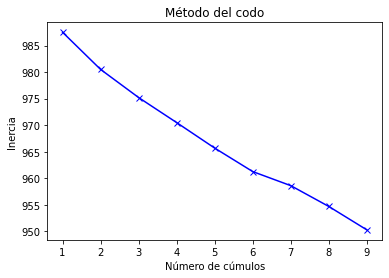

In [12]:
plt.xlabel('Número de cúmulos')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.plot(ks, k_inertias, 'bx-');

###  `[10 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [13]:
k = 6
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
data['cluster'] = model.labels_
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,cluster
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry,3
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games,2
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games,0
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games,4
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games,4


###  `[15 pts]` Punto 4: Interpretación de los clusters

In [15]:
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)

centroids = model.cluster_centers_

terms = tfidf_vect.get_feature_names()
order_centroids = centroids.argsort()[:, ::-1]

for i in range(k):
    print(f"Cluster # {i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")
    print()
    
    print("TÉRMINOS MÁS REPRESENTATIVOS")
    for ind in order_centroids[i][:20]:
        print(terms[ind], end=" ")
    print()
    print()
    
    print(f"DOCUMENTOS MÁS REPRESENTATIVOS")
    for vecino in data.iloc[nbrs.kneighbors([centroids[i]])[1][0]].review_body.values:
        print(f" *** {vecino}")
        print()
        
    print()
    print("********************************************")
    print()

Cluster # 0
Tiene 619 registros (61.90% de los datos)

TÉRMINOS MÁS REPRESENTATIVOS
juego producto si llegado regalo mas día bonitos foto precio mando jugar puede mal esperaba llego tiempo aunque solo pulsera 

DOCUMENTOS MÁS REPRESENTATIVOS
 *** El juego en sí es increíble. A estas alturas de la generación poco más se puede decir salvo que es el simulador de conducción por excelencia, el mejor en su género en consolas. El pero viene por el envío de Amazon. El juego me lo envían sin precinto original, abierto, probablemente procedente de alguna devolución, cosa que no especifican en ningún momento. Además y para colmo, la caja vino con una de las pestañas rotas. Impresionante el mal gusto por parte de Amazon al enviar el producto de esta manera: Gracias a dios el disco está impoluto y el precio aún así mereció la pena, pero me tocará comprar algún juego de segunda mano barato para cambiar la caja.

 *** Esperaba más del juego.

 *** Aunque la caja está en italiano, el juego está en mul

CLUSTERS:

Cluster 0:
COUNT  52 comments (5.20% of the data)
TERMS  perfecto llegó tiempo gracias sido rápido justo juego tamaño producto recomendable rapido poner funciona igual funcionar buen mano castellano encanta 
REPRESENTATIVE COMMENTS
* Todo en perfecto estado
* Perfecto y en tiempo
* Llegó a tiempo y en perfecto estado


Cluster 1:
COUNT  211 comments (21.10% of the data)
TERMS  bien juego bastante aunque cadena funciona si viene español caja dos jugar solo producto mas regalo precio ps así imagen 
REPRESENTATIVE COMMENTS
* Está bien por su precio
* Por el precio que tiene está muy bien
* Esta bien,fue un regalo


Cluster 2:
COUNT  551 comments (55.10% of the data)
TERMS  producto llegado si buen regalo día mas bonitos foto mando bonita llego pulsera solo plata llegó pequeños tiempo mal amazon 
REPRESENTATIVE COMMENTS
* El producto ha llegado antes de lo previsto, me ha gustado su calidad es más pequeño de lo esperado pero me gusta. Vale la pena.
* No ha llegado el collar . La

###  `[BONUS: 3 pts]` Visualización usando PCA

In [17]:
clusters = {0: 'Grupo 1',
            1: 'Grupo 2',
            2: 'Grupo 3',
            3: 'Grupo 4',
            4: 'Grupo 5',
            5: 'Grupo 6'}

data['nombres_clusters'] = data['cluster'].apply(lambda val: clusters[val])
df_centroids = pd.DataFrame(centroids)
df_centroids['cluster'] = clusters.values()

In [18]:
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X','Y']
result['clusters'] = data.nombres_clusters.values
result['texto'] = data.review_body.apply(lambda val: val[:140])

result.head()

,X,Y,clusters,texto
0,0.486783,-0.322567,Grupo 4,"Buen. Buena calidad, y buena presentación."
1,-0.106868,-0.147200,Grupo 3,"Un producto a perfecto, para salir de casa con..."
2,-0.071147,-0.029136,Grupo 1,No funciona con Nintendo Switch. No hay forma ...
3,0.031713,0.233339,Grupo 5,"Recomendado, los utilizo para pc y no me dan n..."
4,0.016512,0.097253,Grupo 5,El cable funciona bien podria ser un poco mas ...


In [19]:
colorsIdx = {'Grupo 1': 'blue',
             'Grupo 2': 'yellow',
             'Grupo 3': 'green',
             'Grupo 4': 'red',
             'Grupo 5': 'purple',
             'Grupo 6': 'orange'}

result['colores'] = result['clusters'].map(colorsIdx)

result.head()

,X,Y,clusters,texto,colores
0,0.486783,-0.322567,Grupo 4,"Buen. Buena calidad, y buena presentación.",red
1,-0.106868,-0.147200,Grupo 3,"Un producto a perfecto, para salir de casa con...",green
2,-0.071147,-0.029136,Grupo 1,No funciona con Nintendo Switch. No hay forma ...,blue
3,0.031713,0.233339,Grupo 5,"Recomendado, los utilizo para pc y no me dan n...",purple
4,0.016512,0.097253,Grupo 5,El cable funciona bien podria ser un poco mas ...,purple


In [20]:
trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['colores'].values)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

In [21]:
## Andres Felipe Murillo

## trabajado en conjunto con Robinson Vela